In [1]:
"""
July 7, 2020

Adding another blob
"""


import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

Ms = np.linspace(7, 12, 60)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

# blob 2: the sfrd
blob_n2 = ['galaxy_sfrd']
blob_i2 = [('z', redshifts)]
blob_f2 = ['SFRD']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1, blob_n2],
 'blob_ivars': [blob_i1, blob_i2],
 'blob_funcs': [blob_f1, blob_f2],
 'blob_kwargs': [None] * 2,
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

In [6]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]',
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(0, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')
# ps.add_distribution(UniformDistribution(0, 2),  'pq_func_par2[3]')

#to actually use
# ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

# ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
# ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

# ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
# ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

# ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
# ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [7]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

In [8]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

In [9]:
# base_pars.update(guesses)
# pop = ares.populations.GalaxyPopulation(**base_pars)

# z = 1

# smf = pop.StellarMassFunction(z, Ms)
# pl.semilogy(Ms, smf, label='guess')
# data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

# pl.legend()
# pl.show()

In [10]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [11]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 16

fitter.jitter = [0.1] * len(fitter.parameters)

fitter.guesses = guesses

# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.0003245014287005417 to 0.23859182041713717
# Fixing position of walker 7 (parameter pq_func_par0[1])
# Moved from -0.20711028219577354 to 0.049851845116681684
# Fixing position of walker 10 (parameter pq_func_par0[1])
# Moved from -0.06889207971000828 to 0.23859182041713717


In [ ]:
fitter.run('MCMC_files/blob_test4', burn=5, steps=30, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Wed Jul  8 16:17:40 2020
# Wrote MCMC_files/blob_test4.burn.dd0000.facc.pkl: Wed Jul  8 16:19:11 2020
# Wrote MCMC_files/blob_test4.burn.dd0001.facc.pkl: Wed Jul  8 16:19:47 2020
# Wrote MCMC_files/blob_test4.burn.dd0002.facc.pkl: Wed Jul  8 16:20:26 2020
# Wrote MCMC_files/blob_test4.burn.dd0003.facc.pkl: Wed Jul  8 16:21:05 2020
# Wrote MCMC_files/blob_test4.burn.dd0004.facc.pkl: Wed Jul  8 16:21:34 2020
# Burn-in complete in 233 seconds.
# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.049959897800849244 to 0.0015505266083729388
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.02926475399349833 to 0.01930331428235916
# Fixing position of walker 10 (parameter pq_func_par0[1])
# Moved from -0.013706293526178377 to 0.011323600803101113
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.030789044534647175 to 0.011323600803101113
# Fixing position of

In [25]:
anl = ares.analysis.ModelSet('MCMC_files/blob_test3')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run2')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels

# anl.skip = 5000


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : blob_test3                                                                             ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/blob_test3.dd*.chain.pkl...
# Loaded MCMC_files/blob_test3.dd*.chain.pkl in 0.28 s.
# Loaded MCMC_files\blob_test3.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0009.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0010.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0011.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0012.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0013.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\blob_test3.dd0014.blo

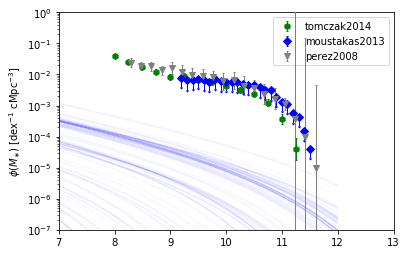

In [26]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [27]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.197933e+00
pq_func_par2[0]: 1.768469e-01
pq_func_par0[1]: 1.879471e-01
pq_func_par2[1]: -5.819696e-01
pq_func_par0[2]: 6.279363e-01
pq_func_par2[2]: -1.844331e-01
pq_func_par0[3]: 1.180889e+01
pq_func_par2[3]: 2.494447e-01


0 of 384 chain elements ignored because of chain links with inf's/nan's.


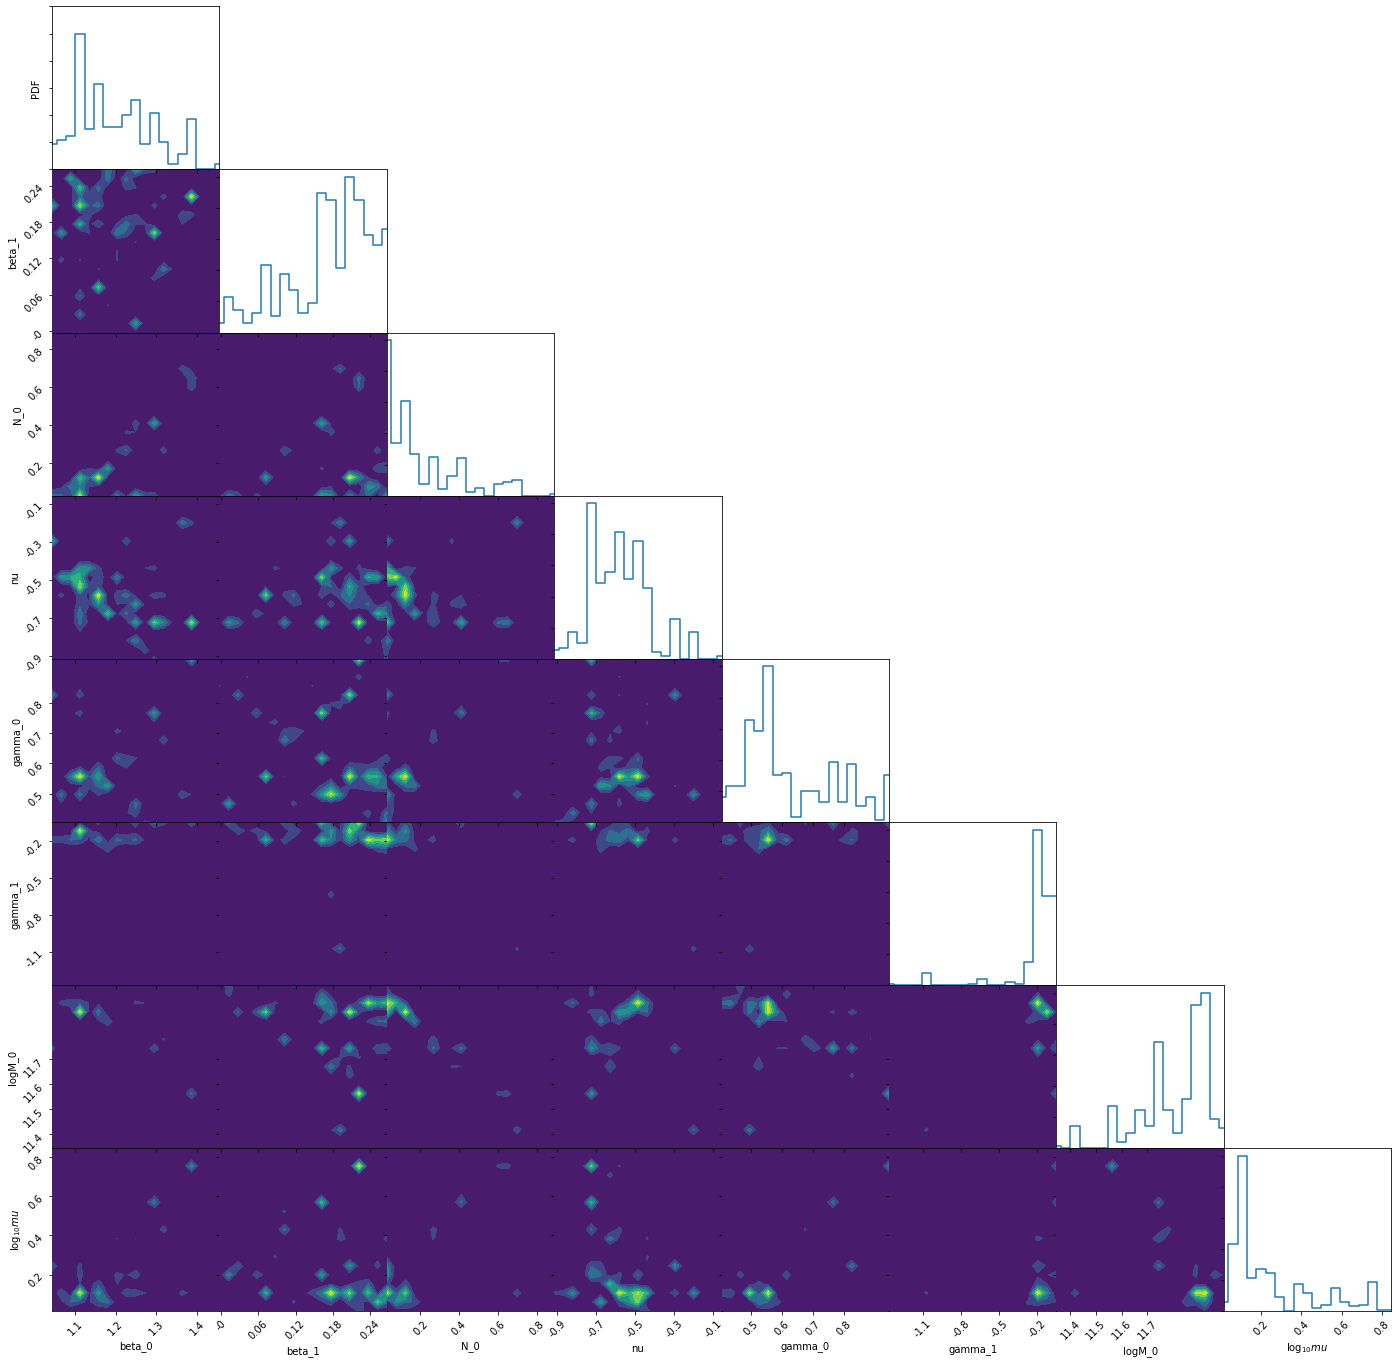

In [28]:

trig = anl.TrianglePlot(pars=params)

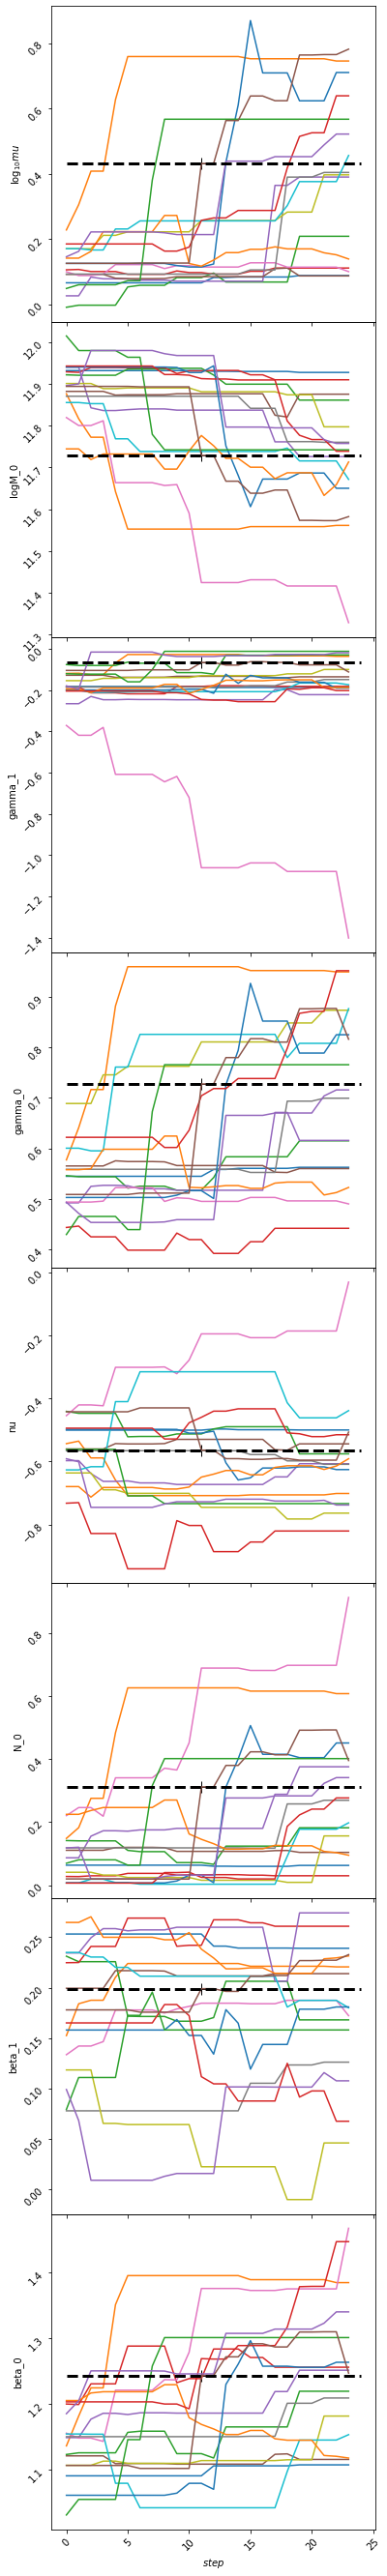

In [29]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [31]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 1.2431617090997635,
 'pq_func_par2[0]': 0.19893873675304996,
 'pq_func_par0[1]': 0.31192447126956024,
 'pq_func_par2[1]': -0.5639931242850855,
 'pq_func_par0[2]': 0.7277806827049561,
 'pq_func_par2[2]': -0.06556509615561351,
 'pq_func_par0[3]': 11.72894506577168,
 'pq_func_par2[3]': 2.7024496746195874}

In [32]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.197933e+00
pq_func_par2[0]: 1.768469e-01
pq_func_par0[1]: 1.879471e-01
pq_func_par2[1]: -5.819696e-01
pq_func_par0[2]: 6.279363e-01
pq_func_par2[2]: -1.844331e-01
pq_func_par0[3]: 1.180889e+01
pq_func_par2[3]: 2.494447e-01


In [33]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [34]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.2431617090997635, array([0.05756676, 0.13673069]))
(0.19893873675304996, array([0.04215461, 0.09737303]))
(0.31192447126956024, array([0.0896197 , 0.29196539]))
(-0.5639931242850855, array([0.10801979, 0.16564105]))
(0.7277806827049561, array([0.08323241, 0.22695277]))
(-0.06556509615561351, array([0.03135808, 0.14735963]))
(11.72894506577168, array([0.20345971, 0.04629106]))
(0.43175761521054146, array([0.09012713, 0.34782732]))


In [35]:
pars_best = ares.util.ParameterBundle("emma:model1")

print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

{'pq_func_par0[0]': 1.2431617090997635, 'pq_func_par2[0]': 0.19893873675304996, 'pq_func_par0[1]': 0.31192447126956024, 'pq_func_par2[1]': -0.5639931242850855, 'pq_func_par0[2]': 0.7277806827049561, 'pq_func_par2[2]': -0.06556509615561351, 'pq_func_par0[3]': 11.72894506577168, 'pq_func_par2[3]': 2.7024496746195874}


# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
SM now
[5.27771691e-26 5.56639465e-26 5.87086233e-26 ... 1.07677787e+07
 1.13567489e+07 1.19779343e+07]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
SM now
[7.82052317e-08 8.23823359e-08 8.67825480e-08 ... 2.65378216e+14
 2.67869966e+14 2.70385111e+14]


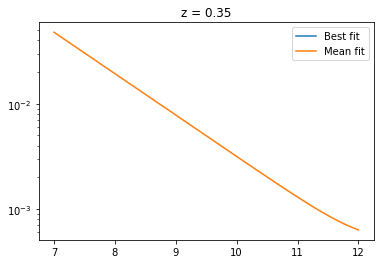

In [36]:
z = 0.35

Ms_short = np.linspace(7, 12, 80)
# Ms_short = [1e9]

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms_short)

print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms_short)

obslf = ares.analysis.GalaxyPopulation()
# obslf.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.semilogy(Ms_short, ls_best, label='Best fit')

pl.semilogy(Ms_short, ls_mean, label='Mean fit')

pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-15, 1e2)
pl.show()

# Loaded MCMC_files\blob_test3.dd0000.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0001.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0002.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0003.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0004.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0005.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0006.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0007.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0008.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0009.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0010.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0011.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0012.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0013.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0014.blob_1d.galaxy_sfrd.pkl
# Loaded MCMC_files\blob_test3.dd0015.blob_1d.galaxy_sfrd.pkl
# Loaded

ValueError: x and y must have same first dimension, but have shapes (15,) and (1, 2, 15, 384)

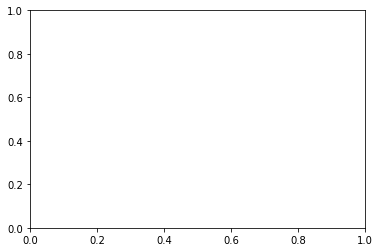

In [37]:
Zs = np.linspace(0, 4, 50)

# print(Ms)

ax = anl.ReconstructedFunction('galaxy_sfrd', ivar=[z], samples='all', color='b', alpha=0.01)

SFRD_mod = pop_best.SFRD(Zs)
# print(SFRD_mod)

# pl.semilogy(Zs, SFRD[0], label="model")
# pl.fill_between(Zs, SFRD[0]-SFRD[1], SFRD[0]+SFRD[1], alpha=0.25) #do these do the logy axis properly?

pl.semilogy(Zs, SFRD_mod[0], label="best fit")

# pl.errorbar(csfrs[0], 10**csfrs[1], yerr=[err1, err2], ls="", marker="o", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.show()
